#  도구(Tool) 추가

챗봇이 "기억만으로" 답변할 수 없는 질문을 처리하기 위해서 `웹 검색 도구`를 사용하도록 합니다. 챗봇은 이 도구를 사용하여 관련 정보를 찾고 더 나은 답변을 제공할 수 있습니다.

## 1. 환경 설정

### `.env`파일 설정

이번 튜토리얼에서는 웹 검색도구로 `Tavily 검색 엔진`을 사용합니다. [Tavily 검색 엔진](https://python.langchain.com/docs/integrations/tools/tavily_search/)을 위한 API 키를 `.env`파일에 등록하세요. 

### 패키지 설치

In [3]:
%pip install -qU python-dotenv langgraph langsmith langchain-openai langchain-tavily

Note: you may need to restart the kernel to use updated packages.


In [33]:
# 환경 변수 확인
from dotenv import load_dotenv
import os
load_dotenv(override=True)

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

print(os.environ.get("OPENAI_API_KEY")[:20])
print(os.environ.get("TAVILY_API_KEY")[:20])


sk-proj-8xZc3Ppf7BtK
tvly-dev-GUT1o6jP4Og


## 2. 도구 정의

웹 검색을 위한 도구를 정의합니다. 이 튜토리얼에서는 [Tavily](https://www.tavily.com/) 서비스를 도구로 사용합니다. 도구를 사용하기 위해서는 API키의 등록이 필요합니다.

In [34]:
from langchain_tavily import TavilySearch

search_tool = TavilySearch(max_results=2)
tools = [search_tool]

In [35]:
# 테스트
search_tool.invoke("2024 한국 프로야구 우승팀을 알려줘")

{'query': '2024 한국 프로야구 우승팀을 알려줘',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://blog.naver.com/travelguide_94/223637975869',
   'title': '2024 프로야구 한국시리즈 우승팀은 기아 타이거즈! KBO 최종 순위 정보',
   'content': '... 우승은. 7년 만의 통합 우승인. 기아 타이거즈가 가져가게 되었는데요. 내년에는 과연 어떤 팀이. 우승을 할지도 궁금해지네요:) \u200b. 결론,. 야구 쪼오온잼',
   'score': 0.85567063,
   'raw_content': None},
  {'url': 'https://namu.wiki/w/2024%20%EC%8B%A0%ED%95%9C%20SOL%20Bank%20KBO%20%ED%95%9C%EA%B5%AD%EC%8B%9C%EB%A6%AC%EC%A6%88',
   'title': '2024 신한 SOL Bank KBO 한국시리즈 - 나무위키',
   'content': '2024 프로야구 챔피언, KBO 최다 우승팀, 열두 번째 우승, KIA 타이거즈! 최초의 80년대생 감독 이범호 감독은 팬들에게 했던 우승의 약속을 지켰고, KBO 리그의',
   'score': 0.7750779,
   'raw_content': None}],
 'response_time': 1.13}

## 3. 그래프 정의

LLM이 검색 도구를 사용할 수 있도록 `bind_tools()` 함수를 사용하여 등록합니다.

In [36]:
from typing import Annotated
from langchain.chat_models import init_chat_model
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    # 수정: LLM이 검색 엔진을 사용할 수 있도록 LLM에게 알려줍니다. 
    llm_with_tools = llm.bind_tools(tools)
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

In [37]:
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

## 4. 도구 실행 위한 노드

LangGraph에는 도구 실행을 위한 미리 정의된(prebuilt) 노드가 준비되어있습니다. `ToolNode`를 그래프에 추가합니다.

In [38]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools)
graph_builder.add_node("tools", tool_node)

## 조건부 엣지(Conditional Edge) 추가

조건부 엣지(conditional edges) 는 하나의 노드에서 시작되며, 현재 그래프 상태에 따라 서로 다른 노드로 이동하기 위해 사용됩니다.  
`tools_condition` 는 LLM의 리턴값에 도구 호출이 필요하면 Tool노드로 이동시키고, 그렇지 않으면 `END`노드로 이동시킨다.  

In [39]:
from langgraph.prebuilt import tools_condition

# `tools_condition` 함수는 챗봇이 도구 사용을 요청하면 "tools"를 반환하고,
# 바로 응답해도 되는 경우에는 "END"를 반환합니다.
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

In [40]:
# 도구가 호출될 때마다, 다음 단계를 결정하기 위해 다시 챗봇으로 돌아갑니다.
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile()

이 부분은 LangGraph에서 제공하는 [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition) 을 사용하면 간격하게 작성할 수 있다.

## 5. 시각화

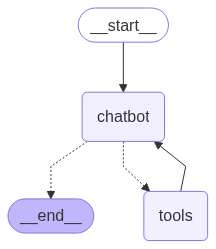

In [41]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

## 6. 챗봇 실행

In [42]:
# You can exit the chat loop at any time by typing `quit`, `exit`, or `q`.
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
            
        for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
            for value in event.values():
                print("Assistant:", value["messages"][-1].content)
    except:
        # input()을 사용할 수 없는 경우의 대체 처리(fallback)
        user_input = "지구에서 달까지의 거리를 알려줘?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  2025년 윔브던 테니스 대회는 어떻게 되고 있나


Assistant: 
Assistant: {"query": "2025 Wimbledon Tennis Championships", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.greenwichtime.com/sports/article/yes-wimbledon-can-be-serious-about-getting-rid-20402190.php", "title": "Yes, Wimbledon can be serious about getting rid of line judges and switching to electronic calls - Greenwich Time", "score": 0.88822687, "published_date": "Tue, 01 Jul 2025 10:20:57 GMT", "content": "Image 1: General view during the round women's single match between Diane Perry of France and Petra Martic of Croatia at the Wimbledon Tennis Championships in London, Monday, June 30, 2025. Image 2: Aryna Sabalenka of Belarus reacts during her match against Carson Branstine of Canada at their first round women's single match at the Wimbledon Tennis Championships in London, Monday, June 30, 2025. Image 3: Matteo Berrettini of Italy serves to Kamil Majchrzak of Poland in their first round men's singles match at the Wimbledon Te

User:  2024년 미국 대선 결과는 어떤가?


Assistant: 
Assistant: {"query": "2024년 미국 대선 결과", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.usatoday.com/elections/results/2024-11-05", "title": "2024 U.S. Election: Live Results and Maps - USA TODAY", "score": 0.735737, "published_date": "Mon, 04 Nov 2024 17:11:05 GMT", "content": "2024 U.S. Election: Live Results and Maps State Results Advertisement - scroll for more content Advertisement - scroll for more content 2024 U.S. Election Results Heading into Election Day, Democrat Kamala Harris and Republican Donald Trump were locked in a tight race for the White House, and control of both the U.S. Senate and House was hanging in the balance. | Electoral Votes | ArizonaAZ11 | GeorgiaGA16 | MichiganMI15 | North CarolinaNC16 | NevadaNV6 | PennsylvaniaPA19 | WisconsinWI10 | Full Presidential Results U.S. Senate Full U.S. Senate Results No results U.S. House Full U.S. House Results No results Advertisement Advertisement - scroll for more cont

User:  2025년 윔블던 대회는 얼만큼 진행중인가


Assistant: 
Assistant: {"query": "2025 Wimbledon Championship progress", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.greenwichtime.com/sports/article/photo-highlights-from-the-first-and-second-rounds-20421777.php", "title": "Photo highlights from the first and second rounds of Wimbledon - Greenwich Time", "score": 0.7498395, "published_date": "Thu, 03 Jul 2025 22:00:45 GMT", "content": "Image 2: Carlos Alcaraz of Spain returns the ball to Oliver Tarvet of Britain in his second round men's singles match at the Wimbledon Tennis Championships in London, Wednesday, July 2, 2025. Image 10: Argentina's Solana Sierra returns to Katie Boulter of Britain during their second round women's singles match at the Wimbledon Tennis Championships in London, Wednesday, July 2, 2025. Image 28: General view as Gael Monfils of France plays a return to Marton Fucsovics of Hungary in their second round men's singles match at the Wimbledon Tennis Championships i

User:  exit


또 만나요!


## 전체 코드

- `BasicToolNode`는  [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode)로 사용
- `route_tools`는  [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition)로 사용

In [ ]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]

def chatbot(state: State):
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    llm_with_tools = llm.bind_tools(tools)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

# 📌 ToolNode 추가
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# 
graph_builder.add_conditional_edges(
    "chatbot",
    # 📌 "tools" 또는 END를 리턴한다.
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()